# Datos
**Nombre:**

**Número de alumno:**

A continuación, debes establecer una *seed* en base a tu número de alumno para que tus resultados sean replicables:

In [40]:
# Sets a random seed for replicable values
import random
random.seed(19639775)

Importar librerias externas

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# 1. Árboles de Decisión y Random Forest
## Actividad 1

Leemos y guardamos la data en un df de pandas

In [42]:
df = pd.read_csv("data.csv")
df.head(5)

,Date,Customers,Customers Thousands,Open,Closed,Promo,Store,StateHoliday,SchoolHoliday,DayOfWeek,Sales
0,2015-02-25,616.0,0.616,YES,NO,0.0,340.0,0,NO,3.0,4923.0
1,2014-05-08,476.0,0.476,YES,NO,1.0,1013.0,0,NO,4.0,4562.0
2,2013-02-27,635.0,0.635,YES,NO,0.0,588.0,0,NO,3.0,5293.0
3,2014-04-30,1581.0,1.581,YES,NO,1.0,344.0,0,YES,3.0,12667.0
4,2013-05-13,595.0,0.595,YES,NO,1.0,766.0,0,NO,1.0,7529.0


In [43]:
print(f"total de datos: {len(df)}")

total de datos: 100000


Limpiamos la informacion redundante: 'Customers thousands' nos ofrecia la misma informacion que 'Customers' al igual que 'Closed' con 'Open'. Por otro lado, tambien se elimina 'Date' y 'Store' dado que no nos entrega información util para un Arbol de Decisión, representan información demasiado especifica de cada fila, por lo que su uso nos dividiaría en demasiadas subcategorias que no nos permitirían generalizar (overfitting).

In [44]:
df = df.drop(['Customers Thousands', 'Closed', 'Date', 'Store'], 1)

df.head()


,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales
0,616.0,YES,0.0,0,NO,3.0,4923.0
1,476.0,YES,1.0,0,NO,4.0,4562.0
2,635.0,YES,0.0,0,NO,3.0,5293.0
3,1581.0,YES,1.0,0,YES,3.0,12667.0
4,595.0,YES,1.0,0,NO,1.0,7529.0


In [45]:
# borramos las filas que tengan valores nulos NAN
df = df.dropna()
print(f"total de datos: {len(df)}")

total de datos: 99999


## Actividad 2

LabelEncoder de sklearn permite codificar de forma discreta las distintas n etiquetas de un atributo numernadolas desde 0..n-1. Su metodo fit recibe el conjunto de valores que deseamos transformar. Posteriormente, el metodo transform reemplaza los valores únicos identificados por los valores numéricos equivalentes. Adicionalmente, el metodo fit_transform agrupa a los dos ultimos metodos, recibiendo los elementos que serán transformados y devolviendonos el df ya codificado.
Su uso nos permitirá tomar columnas con objetos no numericos, en este caso: 'Open', 'StateHoliday' y 'SchoolHoliday', y transformarlas en valores númericos, permitiendonos asi su correcto analisis e integracion en nuestro arbol.


In [46]:
from sklearn import preprocessing

# elegimos las columnas que queremos transformar
categ = ['Open','StateHoliday','SchoolHoliday']

# Encode Categorical Columns
le = preprocessing.LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)
df.head()

,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek,Sales
0,616.0,1,0.0,0,0,3.0,4923.0
1,476.0,1,1.0,0,0,4.0,4562.0
2,635.0,1,0.0,0,0,3.0,5293.0
3,1581.0,1,1.0,0,1,3.0,12667.0
4,595.0,1,1.0,0,0,1.0,7529.0


## Actividad 3

Debemos discretizar los niveles de ventas en 5 categorias distintas. Para esto, primero debemos notar que existe una gran cantidad de dias en los que la tienda estuvo cerrada y, por lo tanto, tuvo 0 ventas. Al observar un histograma de los datos se observa como si sacamos estos datos obtenemos una distribucion normal.

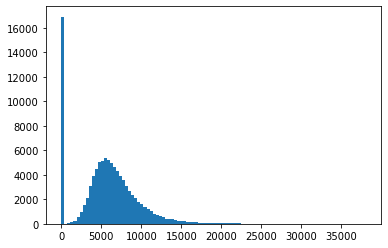

In [47]:
ventas = df['Sales']

plt.hist(ventas, bins=100);

Debido a esto es que se agregaran los dias con 0 ventas en la categoria de menor ventas, pero no se considerarán a la hora de decidir los cortes.

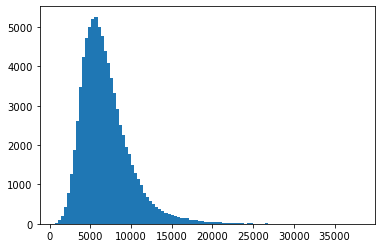

In [48]:
ventas_notzero = ventas.loc[ventas > 0]
plt.hist(ventas_notzero, bins=100);

Dividimos en una simplificacion de una distribucion normal, los datos distintos de cero, en categorias que agrupen segun los percentiles[0, 0.05, 0.2, 0.8, 0.95, 1]. Se eligieron estos valores ya que creo que al igual que una distribucion normal permiten describir de una forma acertada el comportamiento de los valores.
Finalmente se encontrarán los valores de los percentiles para crear las categorias, remplazando el extremo izquierdo de la menor categoria con 0 para incluir todos los datos.

In [49]:
# calculamos los percentiles 
holas = pd.qcut(ventas_notzero, q=[0, 0.05, 0.2, 0.8, 0.95, 1])

holas.value_counts()

(4521.0, 8954.0]      49846
(3176.0, 4521.0]      12462
(8954.0, 12628.2]     12460
(648.999, 3176.0]      4155
(12628.2, 38025.0]     4154
Name: Sales, dtype: int64

In [50]:
# Se obtienen los siguiente contenedores:
# [0,3176), [3176,4521), [4521, 8954), [8954, 12628), [12628, 38026)
contenedores = [-0.0001,3176,4521, 8954, 12628, 39000]


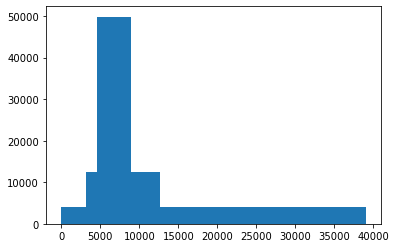

In [51]:
# histograma de las ventas distintas de cero
plt.hist(ventas_notzero, bins=contenedores);


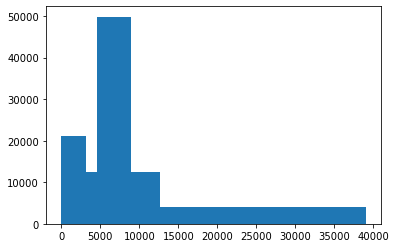

In [52]:
# histograma de todas las ventas
plt.hist(ventas, bins=contenedores);

In [53]:
# Casteamos a int la columna sales que estaba como category
df['Sales'] = pd.cut(df['Sales'],bins=contenedores,labels=range(5)).astype('int')


## Actividad 4

In [54]:
# ordenamos el arreglo de menor a mayor
df_sorted = df.sort_values(by=['Sales'], ascending=True)

df = df_sorted


In [55]:
# separamos las etiquetas de x e y
features = ["Customers", "Open", "Promo", "StateHoliday", "SchoolHoliday", "DayOfWeek"]
target = "Sales"

In [56]:
# Creamos el X
X = df[features]
X.head()

,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfWeek
89062,0.0,0,0.0,1,1,4.0
86383,0.0,0,0.0,0,0,7.0
69578,0.0,0,0.0,0,0,7.0
69577,0.0,0,0.0,0,0,7.0
38124,0.0,0,0.0,0,0,7.0


In [57]:
# Creamos el Y
Y = df[target]
Y.head()

89062    0
86383    0
69578    0
69577    0
38124    0
Name: Sales, dtype: int32

In [58]:
# Separamos los sets de entrenamiento y de test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)


In [59]:
# revisamos la cantidad asignada a cada set

print(f"Cantidad train: {len(X_train)}\nCantidad test: {len(X_test)}")

Cantidad train: 69999
Cantidad test: 30000


In [60]:
# importamos cross validation
from sklearn.model_selection import cross_val_score

Hyperparametros: 
1. n_estimators: corresponde al numero de arboles en el bosque.
2. criterion: función que se usará para medir la calidad de una divison. 'gini' utiliza la función para la impureza de Gini y 'entropy' utiliza la medida de entropia para la ganancia de informacion.
3. max_depth: La profundidad maxima de cada arbol, las niveles de divisiones maximas que se realizan antes de elegir un resultado.

La razón por la que no usamos un set de validacion de forma explicita, es que se utiliza cross validation para este objetivo. La funcion cross validation toma el test de entrenamiento y lo divide en k partes, luego se utilizan k-1 partes para entrenar el set y la k-esima parte para evaluar sus resultados. De esta forma se evalua el rendimiento con cada parte distinta que se utiliza para evaluar, evitando asi resultados que sean especificos para un subset en concreto. Utilizando este metodo no se pierden datos importantes que podrian ser utilizados para el entrenamiento, mientras que se obtiene un buen indicador del rendimiento del modelo.

In [61]:
# creamos un best forest con los hyperparametros 
# (ya se eligieron los mejores)
best_forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=8)


In [62]:
# evaluamos su rendimiento con cross validation
scores = cross_val_score(best_forest, X, Y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.78 accuracy with a standard deviation of 0.00


In [63]:
# entrenamos nuestro bosque
best_forest.fit(X_train, Y_train)

RandomForestClassifier(max_depth=8)

In [64]:
# Evaluamos en el set de test
y_pred = best_forest.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
acc

0.4100666666666667

Si bien los resultados obtenidos a través de cross validation señalan que nuestro modelo deberia ser certero (78%), al enfrentarlo al set de test este rendimiento decae significativamente obteniendo resultados poco deseados(0.41%). Este comportamiento nos indica que el set de test con el set de entrenamiento no guardan una correlación deseada, es decir, el set de entrenamiento no refleja de manera correcta los datos reales a los que se enfretará el modelo. Los buenos resultados del cross validation se explican debido a que se enfretan dentro del mismo set de datos sesgados. Este sesgo de datos es causado debido a que al ordenar los datos, de menor a mayor, y luego separarlos de forma no aleatoria, el set de entrenamiento cuenta con el 70% mas pequeño de datos y, por lo tanto, no posee valores para las dos categorias más altas de ventas (3, 4), las cuales son precisamente las que contentrá el set de test, por lo que fallará prediciendo estos niveles de venta y se obtendrán malos resultados.

In [65]:
# Se juntan los resultados de los test en new_test para poder filtrarlos
new_test = X_test
new_test = new_test.assign(Sales=Y_test.values)

# se filtra en ventas muy altas
new_test = new_test.loc[new_test["Sales"] == 4]

# se separan x e y
Y_new_test = new_test[target]
X_new_test = new_test[features]

# se evalua
y_new_pred = best_forest.predict(X_new_test)
acc = accuracy_score(Y_new_test, y_new_pred)
acc


0.0

Se obtiene un resultado de 0 de preicision, esto debido a que el set de entrenamiento no tuvo ningun dato con valor (4) por lo que nunca predecirá este valor, no hay ningun nodo hoja que clasifique para ventas muy altas. De esta forma, al pasarle el set que solo contiene valor objetivo (4) se obtienen todos los resultados incorrectos.

## Actividad 5

In [66]:
# Se realiza una buena división de los set de entrenamiento y test.
# Al hacer que la division sea aleatoria, se obtiene una cantidad proporcional de los posibles niveles de ventas
# en el set de entrenamiento y el de test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=2)

In [416]:
Y_train.value_counts()

2    34774
0    14807
3     8772
1     8753
4     2893
Name: Sales, dtype: int64

In [67]:
Y_test.value_counts()

2    14907
0     6321
1     3769
3     3730
4     1273
Name: Sales, dtype: int64

Como se observa en las celdas anteriores, los datos ahora están bien distribuidos entre el set de entrenamiento y el de test. De hecho, el set de entrenamiento cuenta con aproximadamente 2.3 veces más datos en cada nivel de ventas. Por lo tanto, ahora el set de entrenamiento y el de test si guardan una fuerte correlacion.

In [68]:
# Se crea el nuevo forest y se evalúa su precision
best_forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=8)
scores = cross_val_score(best_forest, X, Y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.78 accuracy with a standard deviation of 0.00


In [69]:
# entrenamos el forest
best_forest.fit(X_train, Y_train)

RandomForestClassifier(max_depth=8)

In [73]:
# Evaluamos en el set de test
y_pred = best_forest.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
acc

0.7768

Con los nuevos set se obtiene un precision del 77.77%, esto es, 36.77 puntos porcentuales más que con el resultado anterior de 41.00%, es decir, es mucho más preciso que el test anterior. Estos resultados se explican debido a que el set de entrenamiento posee datos que corresponden a todos los posibles valores de venta, permitiendo asi crear nodos hoja para todos las categorias. No solo existen datos para todos los valores, si no que la cantidad de estos es mayor en los niveles más altos, los cuales contienen los datos más dispersos de los niveles de venta, por lo que previamente al no poseer una cantidad minima de datos necesarios para empezar a predecir correctamente, la precision de estos en los test era escasa.

In [75]:
# Se juntan los resultados de los test en new_test para poder filtrarlos
new_test = X_test
new_test = new_test.assign(Sales=Y_test.values)

# se filtra en ventas muy altas
new_test = new_test.loc[new_test["Sales"] == 4]

# se separan x e y
Y_new_test = new_test[target]
X_new_test = new_test[features]

# se evalua
y_new_pred = best_forest.predict(X_new_test)
acc = accuracy_score(Y_new_test, y_new_pred)
acc


0.5632364493322859

La precision en los test de ventas muy altas aumentó desde 0 a 0.56. Este aumento como se mencionó previamente, se debe a la ahora incorporación en el set de entranamiento de datos con nivel de ventas muy alto. Si bien este aumento es grande, la precision sigue siendo baja, esta se puede deber a la poca cantidad de datos con los que se cuenta en el set de entrenamiento y/o a la dispersion de los datos.

## Actividad 6

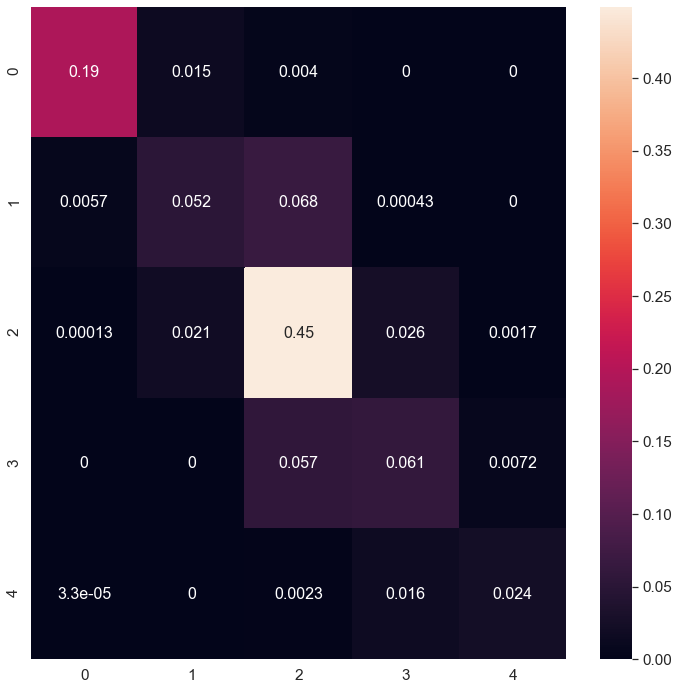

In [76]:
#se importa seaborn para realizar el display de la matriz de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sn

# se crea la matriz para los resultados de la actividad 5 y se normaliza para analizarla mejor
df_cm = confusion_matrix(Y_test, y_pred, normalize='all')

# atributos de la figura
plt.figure(figsize = (12,12))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16});

In [77]:
df_cm2 = confusion_matrix(Y_test, y_pred)
df_cm2

array([[ 5748,   452,   121,     0,     0],
       [  170,  1557,  2029,    13,     0],
       [    4,   623, 13462,   766,    52],
       [    0,     0,  1695,  1820,   215],
       [    1,     0,    70,   485,   717]], dtype=int64)

Lo primero que hay que destacar, es que la gran parte de errores ocurrén al clasificar el nivel de ventas como exactamente uno arriba del indicado o uno abajo de este. De esta forma el 2 se confunda con el 1 y con el 3. el 3 se confunde con el 2 y en una medida mucho menor con el 4. Esta confusión probablemente sea causada por la elección arbitraria de los buckets, en donde al no existir una razón completamente objetiva de esta división se presentan ambiguedades entre las dos clases para los datos cercanos a la frontera.

La confusion más preocupante es la de los datos con nivel de ventas 1 que se predijeron como 2, en donde, incluso se alcanza una mayor frecuencia de los datos incorrectos que los datos del nivel de venta 1 que se predijieron de forma correcta. Otro punto de error importante fueron los datos correspondientes al nivel 3 que se estimaron como 2, en donde, la frecuencia de los errores es casi igual a la de predicciones acertadas. Por ultimo, hubo gran confusion en los datos correspondientes al nivel 4, estimandolos como 3, aunque su frecuencia es menor a la de otros errores, al compararla con la cantidad de aciertos para el nivel 5 se aprecia que existe un alto nivel de confusion.

Se clasificó con mayor frecuencia en un nivel de ventas 3 (tanto correcta como incorrectamente), esto debido a la gran cantidad de datos con los que cuenta este nivel (60% del set de test).

Los 5 errores que ocurrieron con mayor frecuencia fueron:

1. Se clasificaron incorrectamente 2029 filas correspondientes al nivel 2, como 1
2. Se clasificaron incorrectamente 1680 filas correspondientes al nivel 2, como 3
3. Se clasificaron incorrectamente 766 filas correspondientes al nivel 3, como 2
4. Se clasificaron incorrectamente 623 filas correspondientes al nivel 1, como 2
5. Se clasificaron incorrectamente 502 filas correspondientes al nivel 1, como 0





## Actividad 7

Precision corresponde a la division entre verdaderos positivos y los verdaderos positivos sumados a los falsos positivos, es decir Precision = Tp / (Tp + Fp). En otras palabras, corresponde a la cantidad de aciertos que se tuvieron sobre todos los positivos que se calcularon.

Recall corresponde a la division entre verdaderos positivos y los verdaderos positivos sumados a los falsos negativos, es decir, Recall = Tp / (Tp + Fn). En otras palabras, corresponde a la cantidad de aciertos que se tuvieron sobre todos los posibles aciertos que se podrian haber tenido en el set.

La precision es más importante cuando un falso positivo resulta muy costoso. Digamos que hay un apocalipsis zombie y usted tiene un modelo que identifica si una persona está sana y puede pasar al refugio. Obviamente, se quiere dejar entrar a la mayor cantidad de gente posible al refugio, pero dejar entrar a un solo zombie resulta demasiado costoso ya que puede resultar en la muerte de todas las personas del refugio. Este es un caso donde se prioritiza la precision sobre el recall.

El recall es más importante cuando un falso negativo resultaria muy costoso. Por ejemplo, un modelo que identifique maletas sospechosas en un aeropuerto. Aqui el costo de dejar pasar una maleta sospechosa puede ser muy grande, mientras que si revisamos una maleta y esta no posee nada riesgoso, no es nada terrible. Este es un ejemplo donde se prioritza el recall sobre la precision. Se asegura que se identifique la mayor cantidad posible de True positives, aunque para hacer esto tenga que encontrar algunos False positives.

In [79]:
from sklearn.metrics import recall_score,precision_score

precision = precision_score(Y_test, y_pred, average=None)
precision

array([0.97045416, 0.59156535, 0.77470219, 0.59014267, 0.72865854])

In [80]:

recall = recall_score(Y_test, y_pred, average=None)
recall

array([0.90934979, 0.41310692, 0.90306567, 0.48793566, 0.56323645])

## Actividad 8

No se puede utilizar una regresión dado que un random forest nos señala a que categoria pertenece cada elemento. Este elemento corresponde al valor de una hoja y es un valor discreto que representa una categoria. Por lo tanto, no nos entrega un valor continuo como una regresion.

# 2. SVM

SVM es un modelo de *Machine Learning* utilizado principalmente para clasificar, el cual consiste básicamente en encontrar el mejor hiperplano separador de los datos (aquel que maximiza el margen de los vectores de soporte), es decir, no es más (ni menos) que un problema de optimización. Como se ha visto en clases, una de las formas para resolver este problema es a partir de las condiciones de Karush-Kuhn-Tucker (KKT), pero también existen otros métodos de hacerlo, como lo es la técnica de **descenso de gradiente**. Con el descenso de gradiente se busca iterativamente actualizar los parámetros que determinan el hiperplano separador al moverse en la **dirección del gradiente** de la función que queremos maximizar (o minimizar). Esto es:

$$\vec{w}^{(t+1)} = \vec{w}^{(t)} - \mu \cdot \nabla c(\vec{w}^{(t)})$$

Donde $\mu$ es sólo un escalar que determina el tamaño de los pasos en que avanzamos en dirección al gradiente (*learning rate*), mientras que la función que queremos minimizar (función de costo) es la siguiente:

$$c(w) =  \frac{1}{2}||\vec{w}||^2 + C*\sum \limits_{i=1}^{n}(1-y_i*<\vec{x_i},\vec{w}>)$$

Y al derivar $c(\vec{w})$ con respecto a $\vec{w}$:

$$\nabla c(\vec{w}) = \vec{w} - C\sum \limits_{i=1}^{n} y_i \cdot \vec{x_i} $$

Dicho esto, se propone una implementación de un modelo de SVM construido desde cero, es decir, no ocuparemos las funcionalidades que nos provee *sklearn* sino que sólo *numpy*.

In [82]:
!pip -q install celluloid
# Creamos el dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from celluloid import Camera
from IPython.core.display import Video
import celluloid


# Definimos una clase con la implementación de SVM binario
class BinaryClassifierSVM:
    
    # El modelo tiene por defecto el valor de los parametros del hiperplano y C.
    def __init__(self, C=1):
        self.C = C
        self.params = np.array([-1, 1, 1]).astype(float)
    
    # Esta función retornará cuán mal se ajusta nuestra hipótesis actual a los datos
    def funcion_costo(self, X, Y):
        norm = (self.params**2).sum()        # 1. Norma de los parámetros (||B||)
        dist = 1 - Y*np.dot(X,self.params)   # 2. A cuánto estamos actualmente dentro del margen máximo para cada punto!
        dist = dist[dist>0]             # Sólo nos importa las distancias que son mayores a cero,
                                        # porque eso podría significar:
                                        # a) Esta bien clasificada, pero el margen es menor a 1 --> (0 < 1 - Y * <X,w> < 1).
                                        # b) Esta mal clasificado (Y*<x, w> < 0)
        return norm/2, self.C*dist.sum(), norm/2+self.C*dist.sum()
    
    # Esta función calcula el gradiente de nuestra función de costo con respecto a 
    # nuestros parámetros
    def calcular_gradiente(self, X, Y):
        grad_margin = self.params
        dist = 1 - Y*np.dot(X,self.params) # Calculamos la distacia entre los puntos y e hiperplano
        valid_sample = (dist>0).astype(float) # Sólo consideramos los datos que están dentro del margen o mal clasificados
        valid_sample = np.expand_dims(valid_sample,axis=1).repeat(3,axis=1)
        Y = np.expand_dims(Y,axis=1).repeat(3,axis=1)
        grad_clas = -valid_sample*Y*X 

        return grad_margin+self.C*grad_clas.sum(axis=0) # Retornamos el gradiente como la fórmula de arriba
    
    def train(self, X_train, y_train):
        iterations = 50         # Número de iteraciones que tomaremos
        delta = 0.005           # Tamaño de los pasos para cada iteración del Descenso de Gradiente
        
        # Sólo para visualización!! Condiciones iniciales
        self.hyperplane_plot(X_train, y_train, 0, init_conditions=True)
        ##############################################
        
        # Train our SVM
        for iteration in range(1,iterations+1):

            # Calculamos el gradiente!
            grad = self.calcular_gradiente(X_train, y_train)
            # paso en Descenso de Gradiente!
            self.params -= delta*grad
            # Actualizamos desempeño de métricas
            norma, dist, total = self.funcion_costo(X_train, y_train)

            # Sólo para visualización!! Nuevo hiperplano
            self.hyperplane_plot(X_train, y_train, iteration)
        # Creamos animación final
        self.generate_animation()
        
    # Sólo para visualización
    def hyperplane_plot(self, X_train, y_train, iteration, init_conditions=False):
        if init_conditions:
            self.x_line = np.arange(-3,5,0.1)
            fig, self.ax = plt.subplots()
            self.ax.set_ylim([-7, 7])
            self.camera = Camera(fig)
        size = len(X_train) // 2
        line = [-(self.params[-1] + x*self.params[0])/self.params[1] for x in self.x_line]
        self.ax.text(0.5, 1.01, f"Iteración: {iteration} - Costo :{self.funcion_costo(X_train, y_train)[-1]:.2f}", transform=self.ax.transAxes)
        plt.scatter([x[0] for x in X_train[:size]],[x[1] for x in X_train[:size]],color="red")
        plt.scatter([x[0] for x in X_train[size:]],[x[1] for x in X_train[size:]],color="blue")
        plt.plot(self.x_line, line, color = "green")
        self.camera.snap()
    
    # Sólo para visualización
    def generate_animation(self):
        anim = self.camera.animate(blit=True)
        writergif = animation.PillowWriter(fps=30)
        anim.save('result.gif',writer=writergif)
        Video("result.gif", embed=True)
    
    def accuracy(self, X_test, y_test):
        # Calculamos predicciones para nuestro modelo
        preds = np.dot(X_test, self.params) > 0 # Calculamos distancia para cada dato y verificamos su clasificación
        correct = preds == (np.array(y_test) > 0) # Sólo tomamos los datos bien clasificados
        accuracy = correct.astype(int).sum()/correct.shape[0]  
        return 100 * accuracy

Para poner a prueba el modelo creado generaremos un set de datos que sea casi linealmente separable, el cual se muestra a continuación:

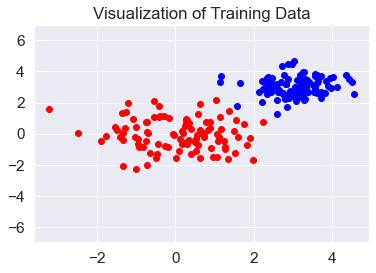

In [83]:
# Simple code to generate the data
# Simple código para generar los datos

size = 100
train_data = []
test_data = []
labels = [-1 for i in range(size)] # Clase negativa
labels += [1 for i in range(size)] # Clase positiva

# Queremos predecir puntos tomados de una distribución normal
mu = [[0,0], [3.0,3.0]]                  # Medias
std = [[[1,0],[0,1]],[[1/3,0], [0,1/3]]] # Matriz de covarianza

# Creamos el set de train
for i in range(len(mu)):
    train_data += list(np.random.multivariate_normal(mu[i],std[i],size))

train_data = np.array(train_data)
train_data = np.c_[ train_data, np.ones(2*size) ]

# Creamos el set de test
for i in range(len(mu)):
    test_data += list(np.random.multivariate_normal(mu[i],std[i],size))

test_data = np.array(test_data)
test_data = np.c_[ test_data, np.ones(2*size) ]

# Graficamos!
# Graficamos condiciones iniciales!
fig, ax = plt.subplots()
ax.set_ylim([-7, 7])
plt.title("Visualization of Training Data")
plt.scatter([x[0] for x in train_data[:size]],[x[1] for x in train_data[:size]],color="red")
plt.scatter([x[0] for x in train_data[size:]],[x[1] for x in train_data[size:]],color="blue")
plt.show()


Podemos entrenar nuestro SVM con estos datos y usarlo para clasificar:

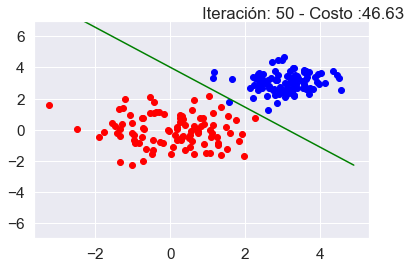

In [84]:
# Instanciamos nuestro modelo con los datos generados
SVM_binary_classifier = BinaryClassifierSVM(C=10)

# Entrenamos el modelo..
SVM_binary_classifier.train(train_data, labels)

Training Accuracy: 99.5%
Test Accuracy: 99.0%


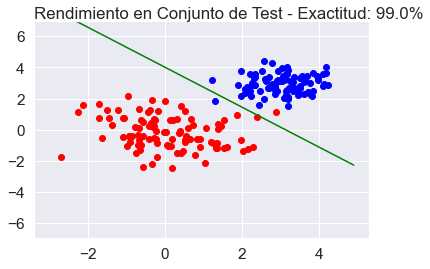

In [85]:
# Accuracy para train y test.
train_accuracy = SVM_binary_classifier.accuracy(train_data, labels)
print(f"Training Accuracy: {train_accuracy}%")

test_accuracy = SVM_binary_classifier.accuracy(test_data, labels)
print(f"Test Accuracy: {test_accuracy}%")

# Visualización del hiperplano en el set de test
x_line = np.arange(-3,5,0.1)
line = [-(SVM_binary_classifier.params[-1] + x*SVM_binary_classifier.params[0])/SVM_binary_classifier.params[1] for x in x_line]
fig, ax = plt.subplots()
ax.text(0.0, 1.01, f"Rendimiento en Conjunto de Test - Exactitud: {test_accuracy}%", transform=ax.transAxes)
ax.set_ylim([-7, 7])
plt.scatter([x[0] for x in test_data[:size]],[x[1] for x in test_data[:size]],color="red")
plt.scatter([x[0] for x in test_data[size:]],[x[1] for x in test_data[size:]],color="blue")
plt.plot(x_line, line, color = "green")
plt.show()


Por último, podemos ver el rendimiento y una gráfica del hiperplano a continuación:

Training Accuracy: 99.5%
Test Accuracy: 99.0%


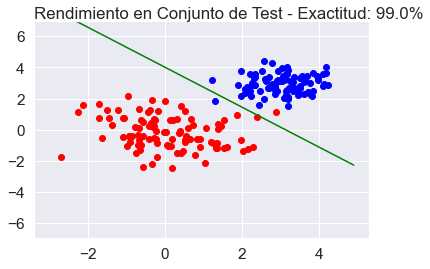

In [86]:
# Accuracy para train y test.
train_accuracy = SVM_binary_classifier.accuracy(train_data, labels)
print(f"Training Accuracy: {train_accuracy}%")

test_accuracy = SVM_binary_classifier.accuracy(test_data, labels)
print(f"Test Accuracy: {test_accuracy}%")

# Visualización del hiperplano en el set de test
x_line = np.arange(-3,5,0.1)
line = [-(SVM_binary_classifier.params[-1] + x*SVM_binary_classifier.params[0])/SVM_binary_classifier.params[1] for x in x_line]
fig, ax = plt.subplots()
ax.text(0.0, 1.01, f"Rendimiento en Conjunto de Test - Exactitud: {test_accuracy}%", transform=ax.transAxes)
ax.set_ylim([-7, 7])
plt.scatter([x[0] for x in test_data[:size]],[x[1] for x in test_data[:size]],color="red")
plt.scatter([x[0] for x in test_data[size:]],[x[1] for x in test_data[size:]],color="blue")
plt.plot(x_line, line, color = "green")
plt.show()

## Actividad 1

Según lo visto en clases podemos usar una estrategia de one-against-all, en donde se creará 1 frontera para cada clase que haya que clasificar, luego se le pide al modelo que esta frontera sea la que mejor clasifique a los datos de su clase. Por lo tanto, en cada iteracion cada frontera se movera dado su respectivo gradiente. Finalmente, cuando se clasifique a un dato nuevo, se le comparará contra todas las fronteras, eligiendo la de mayor valor, es decir, la que lo clasifique de mejor forma.

respecto a nuestro codigo:
    1. Calculamos la funcion del gradiente iterando por cada frontera
    para cada frontera se crea un conjunto nuevo de labels, en los que se les da el valor 1 si corresponde a la clase correcta y 0 para todos los otros.
    Luego se calcula el valor del gradiente para cada una de las fronteras y se devuelve en un array.
    
    2. El entrenamiento es igual que antes, dado que el producto punto entre el gradiente y el array con las fronteras las multiplicara de forma adecuada variando su valor.
    
    3 Para el accuarcy lo unico que hay que cambiar es la forma en la que se revisan los valores, en donde ahora deberán ser iguales a las etiquetas que se nos entregaron de un principio (las cuales incluyen 3 categorias no solo 2).
    
    4. No se implementa la funcion de costos dado que no es necesario

## Actividad 2

In [93]:
class MulticlassClassifierSVM:
    
    # Del mismo modo que la implementación anterior agrego detalles por defecto que tendrá el modelo
    def __init__(self, size=100, C=1, n_classes=3):
        self.C = C
        self.n_classes = n_classes
        self.size = size # Cantidad de datos por cada clase
        # Tendré que generar n planos si tengo n clases
        self.params = np.random.rand(n_classes, 3)
    
    # Esta función retornará cuán mal se ajusta nuestra hipótesis actual a los datos
    def costo_multiclase(self, X, Y):
        # FUNCIÓN A IMPLEMENTAR
        # no se implementó esta funcion dado que no era necesaria para
        # la clasificacion
        
        pass
    
    # Esta función calcula el gradiente de nuestra función de costo con respecto a 
    # nuestros parámetros
    def gradiente_multiclase(self, X, Y):
        array_labels = np.array(labels)
        grad_total = []
        for i in range(self.n_classes):
            y_current = np.where(array_labels == i, 1, -1)

            grad_margin = self.params[i]
            dist = 1 - y_current*np.dot(X,self.params[i]) # Calculamos la distacia entre los puntos y e hiperplano
            valid_sample = (dist>0).astype(float) # Sólo consideramos los datos que están dentro del margen o mal clasificados
            valid_sample = np.expand_dims(valid_sample,axis=1).repeat(3,axis=1)
            y_current = np.expand_dims(y_current,axis=1).repeat(3,axis=1)
            grad_clas = -valid_sample*y_current*X 

            grad_total.append(grad_margin+self.C*grad_clas.sum(axis=0))
        return grad_total

    def train(self, X_train, y_train):
        iterations = 200         # Número de iteraciones que tomaremos
        delta = 0.005           # Tamaño de los pasos para cada iteración del Descenso de Gradiente
        
 
        
        # Train our SVM
        for iteration in range(1,iterations+1):

            # Calculamos el gradiente!
            grad = self.gradiente_multiclase(X_train, y_train)
            # paso en Descenso de Gradiente!
            self.params -= np.dot(delta,grad)
            # Actualizamos desempeño de métricas
            #norma, dist, total = self.funcion_costo(X_train, y_train)

            # Sólo para visualización!! Nuevo hiperplano
            #self.plot_decision_surface(X_train, y_train)
            #self.hyperplane_plot(X_train, y_train, iteration)
        pass
        
    def accuracy(self, X_test, y_test):
        # Calculamos predicciones para nuestro modelo
        preds = self.predict(X_test) # Calculamos distancia para cada dato y verificamos su clasificación
        correct = preds == (np.array(y_test)) # Sólo tomamos los datos bien clasificados
        accuracy = correct.astype(int).sum()/correct.shape[0]  
        return 100 * accuracy
    
    # Función retorna lista con predicciones según X_test
    def predict(self, X_test):
        preds = list()
        for t in X_test:
            maximo = -9
            max_class = -1
            for i, p in enumerate(self.params):
                val = np.dot(p,t)
                if val > maximo:
                    maximo = val
                    max_class = i
            preds.append(max_class)
        return np.array(preds)
        
    def plot_decision_surface(self, X_train, y_train):
        fig, ax = plt.subplots()

        x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
        y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

        Z = self.predict(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title('Superficie de decisión SVM Multiclase')
        ax.legend()
        plt.show()

A continuación, se genera el *dataset* con el que debes trabajar para tu clasificador:

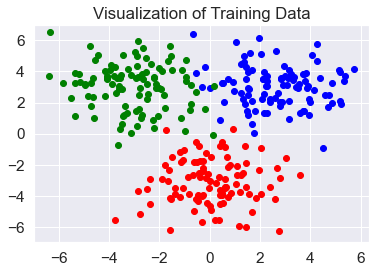

In [95]:
# Data set multiclase:
# Código para generar datos de múltiples clases

n_classes = 3
size = 100
train_data = []
test_data = []
labels = list()
for i in range(n_classes):
    labels += [i for _ in range(size)] # Generamos datos de múltiples clases (100 ejemplos por clase)

# Queremos predecir puntos tomados de una distribución normal
mu = [[0,-3.0], [3.0,3.0], [-3.0,3.0]]                 # Promedios
std = [[[2,0],[0,2]], [[2,0],[0,2]], [[2,0],[0,2]]] # Matriz de covarianza

# Creamos el set de train
for i in range(len(mu)):
    train_data += list(np.random.multivariate_normal(mu[i],std[i],size))

train_data = np.array(train_data)
train_data = np.c_[ train_data, np.ones(n_classes*size) ]

# Creamos el set de test
for i in range(len(mu)):
    test_data += list(np.random.multivariate_normal(mu[i],std[i],size))

test_data = np.array(test_data)
test_data = np.c_[ test_data, np.ones(n_classes*size) ]

# Graficamos!
# Graficamos condiciones iniciales!
fig, ax = plt.subplots()
ax.set_ylim([-7, 7])
colors = ['red','blue','green']
plt.title("Visualization of Training Data")
for i in range(n_classes):
    plt.scatter([x[0] for x in train_data[i*size:(i+1)*size]],[x[1] for x in train_data[i*size:(i+1)*size]],color=colors[i])
plt.show()


No handles with labels found to put in legend.


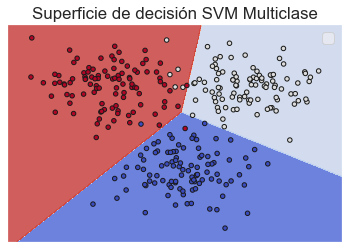

In [96]:
# Acá deberías entrenar tu modelo y graficar..
# Descomenta las siguientes lineas una vez que hayas implementado el modelo

# Instanciamos el modelo
svm_mul_classifier = MulticlassClassifierSVM(C=10)

# Entrenamos el módelo
svm_mul_classifier.train(train_data, labels)

# Graficamos superficie de decisión
svm_mul_classifier.plot_decision_surface(train_data, labels)

No handles with labels found to put in legend.


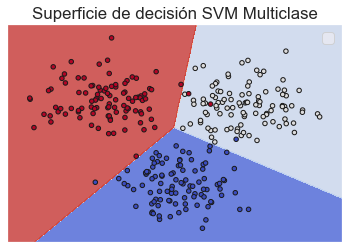

In [98]:
svm_mul_classifier.plot_decision_surface(test_data, labels)

Se te deja un código a continuación para que puedas entrenar y graficar tu modelo (eres libre de modificarlo eventualmente, aunque no debería hacer falta):

Se te deja un código a continuación para que puedas probar el rendimiento de tu modelo (eres libre de modificarlo eventualmente, aunque no debería hacer falta):

In [99]:
# Acá deberías probar el desempeño de tus resultados..
# Descomenta las siguientes lineas una vez que hayas implementado el modelo

# En el set de train
print(f"Train acc: {svm_mul_classifier.accuracy(train_data, labels)}%")

# En el set de test
print(f"Test acc: {svm_mul_classifier.accuracy(test_data, labels)}%")
# Visualización del hiperplano en el set de test
# Visualización del hiperplano en el set de test


Train acc: 97.66666666666667%
Test acc: 98.66666666666667%


Se obtiene un acc bastante alta, obteniendo un 98.66% de resultados correctos en el set de Test. Por lo tanto, podemos decir que nuestro modelo clasifica correctamente.

## Bonus

In [100]:
# se me olvido hasta que vine a entergarlo :c

# Referencias